In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!ls "/content/drive/My Drive/courses/CS677/Final project"
#!ls '/content/drive/My Drive/CS677 Final Project'

 CS677_Final_Model.h5		 GLD_data.csv
 CS677_Final_project_001.ipynb	 Links.txt
 CS677_Final_project_002.ipynb	 Project.docx
 CS677_Final_project_003.ipynb	 SPY_data.csv
 CS677_Final_project_004.ipynb	 TLT_data.csv
'CS677 Final project.ipynb'	'useful material.docx'


In [0]:
import os
os.chdir("/content/drive/My Drive/courses/CS677/Final project")

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import logging

Using TensorFlow backend.


read dataset 

In [6]:
#df_ge=pd.read_csv("D:\Google drive\courses\CS677\Final project\TLT_data.csv")
df_ge=pd.read_csv('TLT_data.csv')
#rename the column names of df_ge
df_ge.columns=["Date", "Open", "High", "Low", "Close", "Volume" ]
df_ge.tail() # we have total 4029 items 

,Date,Open,High,Low,Close,Volume
4205,2019-04-10,124.270,124.52,124.10,124.28,7519916.0
4206,2019-04-11,123.930,124.02,123.41,123.55,8679319.0
4207,2019-04-12,122.890,123.06,122.63,122.67,7005541.0
4208,2019-04-15,122.775,122.99,122.72,122.98,3070036.0
4209,2019-04-16,122.510,122.63,122.14,122.21,8927253.0


In [7]:
# export the weekday and month and add to the dataframe
from datetime import datetime
Weekday=[]
Month=[]
for i in range(len(df_ge)):
  Date=datetime.strptime(df_ge["Date"][i], '%Y-%m-%d')
  Weekday.append(Date.weekday())
  Month.append(Date.month)

df_ge["Week"]=Weekday
df_ge["Month"]=Month
df_ge.tail()

,Date,Open,High,Low,Close,Volume,Week,Month
4205,2019-04-10,124.270,124.52,124.10,124.28,7519916.0,2,4
4206,2019-04-11,123.930,124.02,123.41,123.55,8679319.0,3,4
4207,2019-04-12,122.890,123.06,122.63,122.67,7005541.0,4,4
4208,2019-04-15,122.775,122.99,122.72,122.98,3070036.0,0,4
4209,2019-04-16,122.510,122.63,122.14,122.21,8927253.0,1,4


In [0]:
df_new = pd.DataFrame(columns=['90_Op','90_Hi','90_Lw','90_Cl','180_Op','180_Hi','180_Lw','180_Cl','360_Op','360_Hi','360_Lw','360_Cl'],dtype = float)

for i in range(360,df_ge.shape[0]):
  O90 =  np.mean(df_ge['Open'][(i-90):i])
  O180 = np.mean(df_ge['Open'][(i-180):i])
  O360 = np.mean(df_ge['Open'][(i-360):i])

  H90 =  np.mean(df_ge['High'][(i-90):i])
  H180 = np.mean(df_ge['High'][(i-180):i])
  H360 = np.mean(df_ge['High'][(i-360):i])

  L90 =  np.mean(df_ge['Low'][(i-90):i])
  L180 = np.mean(df_ge['Low'][(i-180):i])
  L360 = np.mean(df_ge['Low'][(i-360):i])

  C90 =  np.mean(df_ge['Close'][(i-90):i])
  C180 = np.mean(df_ge['Close'][(i-180):i])
  C360 = np.mean(df_ge['Close'][(i-360):i])

  df_new.loc[i] = [O90, H90,L90,C90,O180, H180,L180,C180,O360, H360,L360,C360]
  

In [9]:
df_new.head()

,90_Op,90_Hi,90_Lw,90_Cl,180_Op,180_Hi,180_Lw,180_Cl,360_Op,360_Hi,360_Lw,360_Cl
360,84.886711,85.263600,84.518878,84.940333,87.336072,87.726083,86.895161,87.330389,87.305425,87.674097,86.894636,87.303972
361,84.917156,85.293489,84.554211,84.972000,87.328850,87.720694,86.888994,87.323889,87.314119,87.683375,86.903469,87.313250
362,84.942378,85.312600,84.580878,84.995111,87.317961,87.709806,86.879328,87.312556,87.323314,87.692847,86.914525,87.324444
363,84.962044,85.329822,84.601211,85.014222,87.304406,87.694194,86.860494,87.293611,87.332592,87.701708,86.921636,87.332556
364,84.979378,85.341044,84.618767,85.023667,87.280906,87.671861,86.838828,87.272667,87.338314,87.706097,86.927192,87.337250


In [0]:
t1 = df_ge.loc[360:]

t2 = pd.concat([t1,df_new],axis = 1, sort = False)

t3 = pd.DataFrame(columns = t2.columns)
for j in range(t2.shape[0]):
  t3.loc[j] = t2.loc[j+360]
  
df_TLT = t3

plot the prices

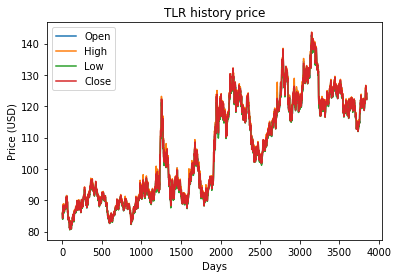

In [11]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(df_TLT["Open"])
plt.plot(df_TLT["High"])
plt.plot(df_TLT["Low"])
plt.plot(df_TLT["Close"])
plt.title('TLR history price')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

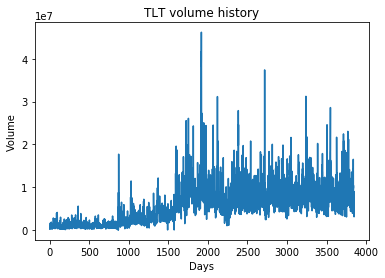

In [12]:
# plot the volume
plt.figure()
plt.plot(df_TLT["Volume"])
plt.title('TLT volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

In [0]:
# hyperparameters
TIME_STEPS = 60
BATCH_SIZE = 32

## Normalizing the data

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ['Open','High','Low','Close','Volume','90_Op','90_Hi','90_Lw','90_Cl','180_Op','180_Hi','180_Lw','180_Cl','360_Op','360_Hi','360_Lw','360_Cl']
min_max_scaler = MinMaxScaler()
x = df_TLT.loc[:, train_cols].values
x = min_max_scaler.fit_transform(x)
xwm = df_TLT.loc[:,['Week','Month']].values
x = np.column_stack((x,xwm))

#df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)


# scale the feature MinMax, build array
#x = df_train.loc[:,train_cols].values
#xwm = df_train.loc[:,['Week','Month']].values
#xwmt = df_test.loc[:,['Week','Month']].values

#min_max_scaler = MinMaxScaler()
#x_train = min_max_scaler.fit_transform(x)
#print(x_train[1:3])
#x_train = np.column_stack((x_train,xwm))
#print(x_train[1:3])
#x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

#x_test = np.column_stack((x_test,xwmt))

# not sure whether the difference between .fit_transform and .transform  



# Converting data to time-series and supervised learning problem

In [0]:
from tqdm._tqdm_notebook import tqdm_notebook
def build_timeseries(mat, y_col_index):
    # y_col_index is list of columns that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0, len(y_col_index)))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [0]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [17]:
x_total, y_total = build_timeseries(x, [0,1,2,3])
np.random.seed(0)
indx = np.arange(x_total.shape[0])
np.random.shuffle(indx)
Bound1 = int(np.floor(len(indx)*0.8))
Bound2 = int(np.floor(len(indx)*0.9))

x_t = x_total[indx[:Bound1],:]
y_t = y_total[indx[:Bound1],:]

x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)


x_val = x_total[indx[Bound1:Bound2],:]
y_val = y_total[indx[Bound1:Bound2],:]

x_val = trim_dataset(x_val, BATCH_SIZE)
y_val = trim_dataset(y_val, BATCH_SIZE)


x_test_t = x_total[indx[Bound2:],:]
y_test_t = y_total[indx[Bound2:],:]

x_test_t = trim_dataset(x_test_t, BATCH_SIZE)
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)



length of time-series i/o (3790, 60, 19) (3790, 4)


# Creating model

In [18]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, LSTM, Dropout
import tensorflow as tf

# cosine learning rate annealing
LR = 0.001
EPOCHS = 200
#def cosine_annealing(x):    
#    lr = LR
#    epochs = EPOCHS
#    return lr*(np.cos(np.pi*x/epochs)+1.)/2
#learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

lstm_model = Sequential()
lstm_model.add(LSTM(1000, return_sequences =True, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(1000, return_sequences = True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(1000))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(200,activation='relu'))
lstm_model.add(Dense(4,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=LR)
#optimizer = optimizers.adam(lr = lr)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

lstm_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (32, 60, 1000)            4080000   
_________________________________________________________________
dropout_1 (Dropout)          (32, 60, 1000)            0         
_________________________________________________________________
lstm_2 (LSTM)                (32, 60, 1000)            8004000   
_________________________________________________________________
dropout_2 (Dropout)          (32, 60, 1000)            0         
_________________________________________________________________
lstm_3 (LSTM)                (32, 1000)                8004000   
_________________________________________________________________
dropout_3 (Dropout)  

# Model training

In [19]:
from keras.callbacks import CSVLogger, EarlyStopping
#csv_logger = CSVLogger("D:\Google drive\courses\CS677\Final project\training.log", append=True)

history = lstm_model.fit(x_t, y_t, epochs=EPOCHS, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, callbacks=[EarlyStopping(monitor = 'val_loss',patience= 15, mode = 'auto')],
                    validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)))


# note that I remove the "callbacks=[csv_logger]" from the model.fit

Instructions for updating:
Use tf.cast instead.
Train on 3008 samples, validate on 352 samples
Epoch 1/200
 - 32s - loss: 0.0783 - val_loss: 0.0623
Epoch 2/200
 - 29s - loss: 0.0647 - val_loss: 0.0617
Epoch 3/200
 - 29s - loss: 0.0537 - val_loss: 0.0079
Epoch 4/200
 - 29s - loss: 0.0134 - val_loss: 0.0122
Epoch 5/200
 - 29s - loss: 0.0111 - val_loss: 0.0058
Epoch 6/200
 - 30s - loss: 0.0081 - val_loss: 0.0040
Epoch 7/200
 - 29s - loss: 0.0068 - val_loss: 0.0038
Epoch 8/200
 - 29s - loss: 0.0057 - val_loss: 0.0038
Epoch 9/200
 - 29s - loss: 0.0049 - val_loss: 0.0030
Epoch 10/200
 - 29s - loss: 0.0054 - val_loss: 0.0022
Epoch 11/200
 - 29s - loss: 0.0037 - val_loss: 0.0022
Epoch 12/200
 - 29s - loss: 0.0043 - val_loss: 0.0046
Epoch 13/200
 - 29s - loss: 0.0046 - val_loss: 0.0065
Epoch 14/200
 - 30s - loss: 0.0029 - val_loss: 0.0028
Epoch 15/200
 - 29s - loss: 0.0039 - val_loss: 0.0030
Epoch 16/200
 - 30s - loss: 0.0024 - val_loss: 8.9269e-04
Epoch 17/200
 - 30s - loss: 0.0021 - val_loss:

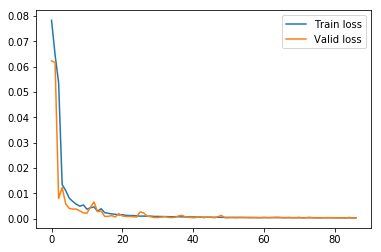

In [20]:
plt.figure()
plt.plot(history.epoch, history.history['loss'],label='Train loss')
plt.plot(history.epoch, history.history['val_loss'],label='Valid loss')
plt.legend()

In [0]:
lstm_model.save('CS677_Final_Model.h5')

In [0]:
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)

In [23]:
print("y_pred shape", y_pred.shape)
print("y_test_t shape", y_test_t.shape)

y_pred shape (352, 4)
y_test_t shape (352, 4)


In [24]:
y_pred[:,0]

array([0.6522621 , 0.2000753 , 0.47638217, 0.46136135, 0.5021951 ,
       0.5871811 , 0.23164701, 0.59306645, 0.6842862 , 0.03256252,
       0.14121872, 0.20962325, 0.7921788 , 0.10062376, 0.1796279 ,
       0.22096583, 0.75149465, 0.6546066 , 0.72165096, 0.67135787,
       0.16959384, 0.6942502 , 0.11638901, 0.05631971, 0.15238112,
       0.2373851 , 0.6659796 , 0.5079284 , 0.09165567, 0.37642998,
       0.20647377, 0.23948371, 0.13915157, 0.69399565, 0.17149326,
       0.14755058, 0.24884272, 0.6457808 , 0.6409717 , 0.09185547,
       0.22342306, 0.27317622, 0.11884132, 0.6483134 , 0.5344635 ,
       0.1283567 , 0.69664955, 0.21572843, 0.60929376, 0.2819694 ,
       0.5704077 , 0.73234284, 0.5684699 , 0.10801706, 0.16768402,
       0.909989  , 0.31025666, 0.5845381 , 0.10833314, 0.12325358,
       0.41656125, 0.14472944, 0.21917471, 0.7311124 , 0.10239848,
       0.6768075 , 0.6422341 , 0.7544048 , 0.22258145, 0.5291043 ,
       0.62910914, 0.9359467 , 0.12387082, 0.38232738, 0.16380

In [25]:
# check the prediction for open price

y_pred_open = y_pred[:,0]
y_test_trim = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_trim[:,0], y_pred_open)
print("Error is", error, y_pred.shape, y_test_t.shape)
#print(y_pred[0:15])
#print(y_test_t[0:15])

Error is 0.00022620296982324404 (352, 4) (352, 4)


In [31]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
MSE=mean_squared_error(y_pred_org, y_test_t_org)
print('MSE is %f' %MSE)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])


MSE is 1.041901
[[121.7099   121.73278  121.92928  121.53372 ]
 [ 93.24474   93.66209   93.30446   93.42937 ]
 [110.63826  111.10026  110.45582  110.51544 ]
 [109.6927   109.87961  109.85767  109.67206 ]
 [112.26318  112.33204  112.45172  112.134155]
 [117.61305  117.66252  117.79016  117.40332 ]
 [ 95.23218   95.7502    95.249596  95.38023 ]
 [117.983536 118.087395 118.12642  117.724686]
 [123.725815 123.74518  123.928024 123.47633 ]
 [ 82.699814  82.8472    82.883675  82.92438 ]
 [ 89.53972   89.83707   89.706375  89.78698 ]
 [ 93.84579   94.25128   93.90067   94.02055 ]
 [130.51765  130.49997  130.68646  130.16035 ]
 [ 86.98427   87.2328    87.21291   87.23029 ]
 [ 91.95758   92.28937   92.05614   92.1655  ]]
[[121.26976351 120.98016746 121.53564333 120.86      ]
 [ 93.77471042  93.75203349  93.46391269  93.27      ]
 [111.00089286 111.74348485 111.4888844  111.79      ]
 [110.67682593 110.63909888 110.79679062 110.73      ]
 [112.49970238 112.61695375 112.15044462 111.6       ]
 [1

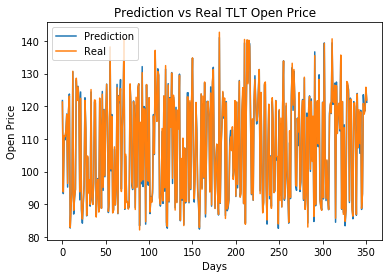

In [27]:
# show prediction and real for open
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org[:,0])
plt.plot(y_test_t_org[:,0])
plt.title('Prediction vs Real TLT Open Price')
plt.ylabel('Open Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
#plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
#print_time("program completed ", stime)

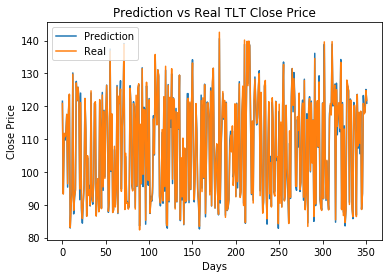

In [28]:
plt.figure()
plt.plot(y_pred_org[:,3])
plt.plot(y_test_t_org[:,3])
plt.title('Prediction vs Real TLT Close Price')
plt.ylabel('Close Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
